In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 2 0 1 0 0 1 0 1 0 1 0 0 1 1]


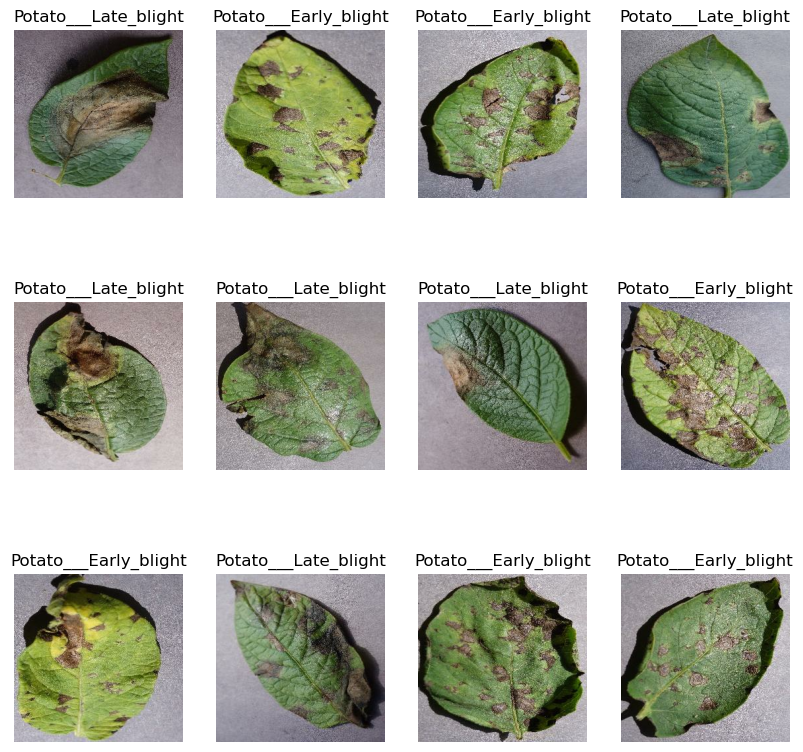

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 72s 1s/step - loss: 0.9177 - accuracy: 0.4740 - val_loss: 0.9418 - val_accuracy: 0.4948
Epoch 2/20
54/54 [==============================] - 69s 1s/step - loss: 0.8388 - accuracy: 0.5631 - val_loss: 0.7067 - val_accuracy: 0.5938
Epoch 3/20
54/54 [==============================] - 68s 1s/step - loss: 0.5049 - accuracy: 0.7674 - val_loss: 0.3649 - val_accuracy: 0.8490
Epoch 4/20
54/54 [==============================] - 69s 1s/step - loss: 0.3599 - accuracy: 0.8507 - val_loss: 0.2944 - val_accuracy: 0.8854
Epoch 5/20
54/54 [==============================] - 69s 1s/step - loss: 0.3035 - accuracy: 0.8750 - val_loss: 0.2856 - val_accuracy: 0.8802
Epoch 6/20
54/54 [==============================] - 69s 1s/step - loss: 0.2620 - accuracy: 0.8970 - val_loss: 0.2890 - val_accuracy: 0.8750
Epoch 7/20
54/54 [==============================] - 81s 2s/step - loss: 0.2648 - accuracy: 0.8935 - val_loss: 0.3862 - val_accuracy: 0.8281
Epoch 8/20
54/54 [==

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 3s 234ms/step - loss: 0.2212 - accuracy: 0.9258


[0.2211941033601761, 0.92578125]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9176506996154785,
 0.838766872882843,
 0.5048757195472717,
 0.35991528630256653,
 0.30345433950424194,
 0.2620077133178711,
 0.26483413577079773,
 0.19373342394828796,
 0.1818256974220276,
 0.1365627646446228,
 0.19588078558444977,
 0.14197923243045807,
 0.10906356573104858,
 0.08238974958658218,
 0.11226004362106323,
 0.12809668481349945,
 0.08488276600837708,
 0.05948496609926224,
 0.08003996312618256,
 0.06091196462512016]

In [16]:
history.history['accuracy']

[0.4739583432674408,
 0.5630787014961243,
 0.7673611044883728,
 0.8506944179534912,
 0.875,
 0.8969907164573669,
 0.8935185074806213,
 0.9224537014961243,
 0.9259259104728699,
 0.9479166865348816,
 0.9184027910232544,
 0.9403935074806213,
 0.9571759104728699,
 0.9710648059844971,
 0.9583333134651184,
 0.9467592835426331,
 0.9693287014961243,
 0.9803240895271301,
 0.9710648059844971,
 0.9768518805503845]

In [17]:
history.history['val_loss']

[0.9418085217475891,
 0.7066646218299866,
 0.3648606538772583,
 0.29440852999687195,
 0.2856326997280121,
 0.28896021842956543,
 0.3862188756465912,
 0.2344036102294922,
 0.26650315523147583,
 0.366049200296402,
 0.493345707654953,
 0.2538715600967407,
 0.506048858165741,
 0.16428618133068085,
 0.1833011507987976,
 0.102436363697052,
 0.34406232833862305,
 0.07012739032506943,
 0.15307815372943878,
 0.330207496881485]

In [18]:
history.history['val_accuracy']

[0.4947916567325592,
 0.59375,
 0.8489583134651184,
 0.8854166865348816,
 0.8802083134651184,
 0.875,
 0.828125,
 0.8854166865348816,
 0.8958333134651184,
 0.8645833134651184,
 0.8020833134651184,
 0.8958333134651184,
 0.84375,
 0.9322916865348816,
 0.9114583134651184,
 0.9427083134651184,
 0.8854166865348816,
 0.953125,
 0.953125,
 0.90625]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

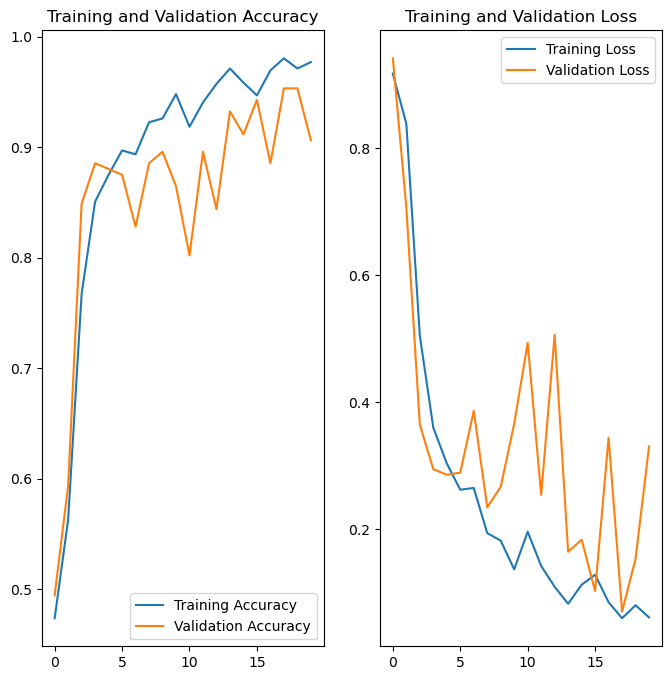

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 310ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


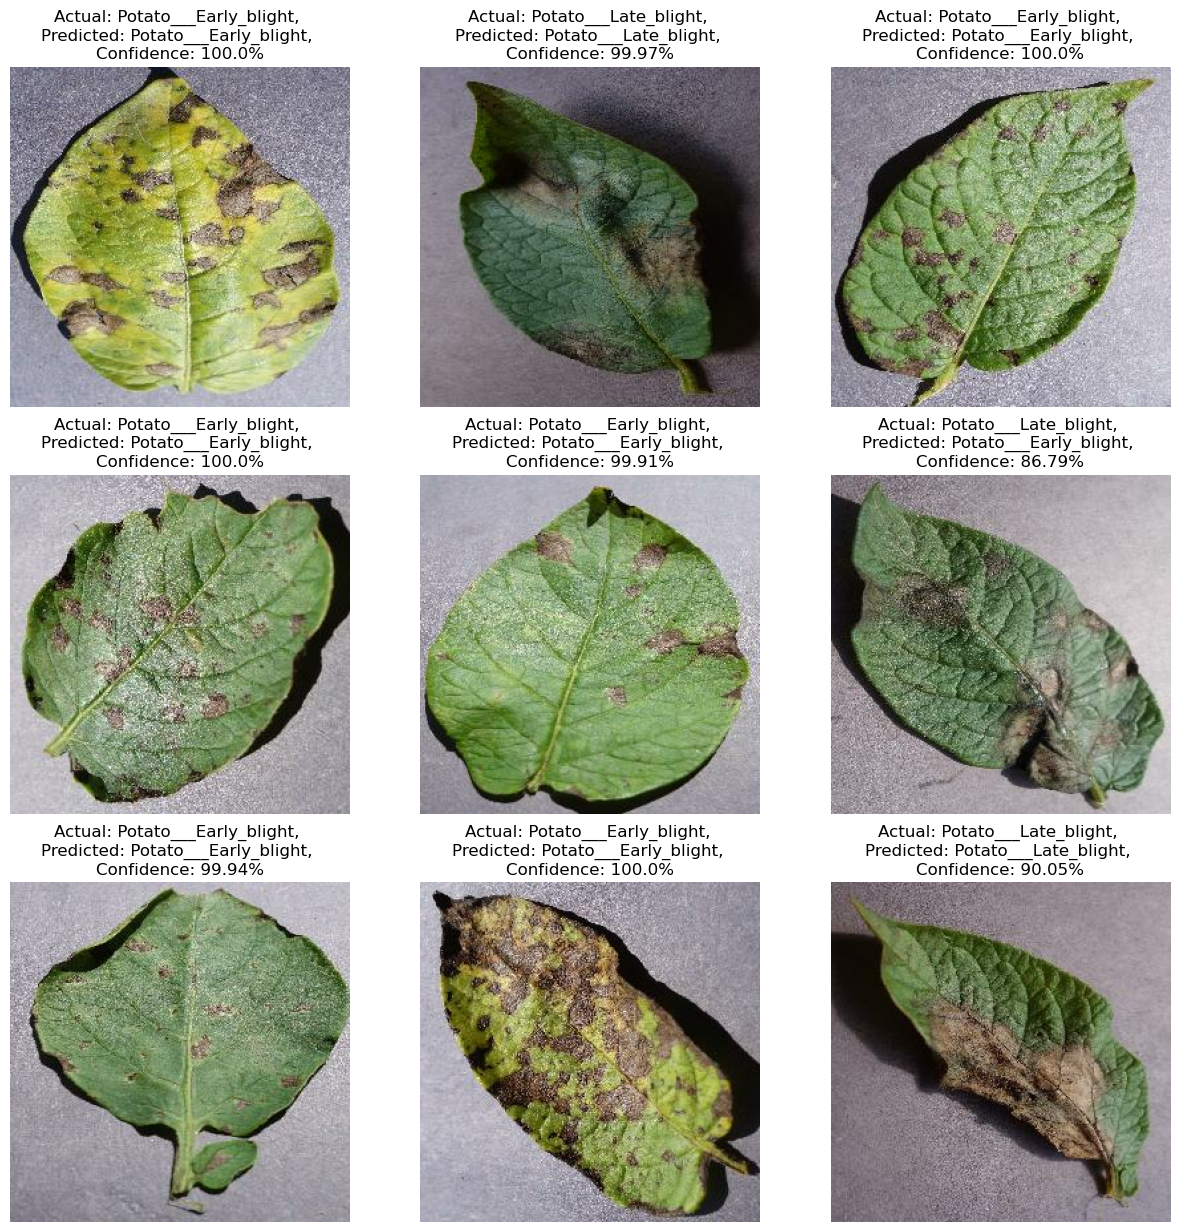

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       130
           1       1.00      0.82      0.90       104
           2       0.85      1.00      0.92        22

    accuracy                           0.93       256
   macro avg       0.91      0.94      0.92       256
weighted avg       0.93      0.93      0.92       256



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[130,   0,   0],
       [ 15,  85,   4],
       [  0,   0,  22]])>

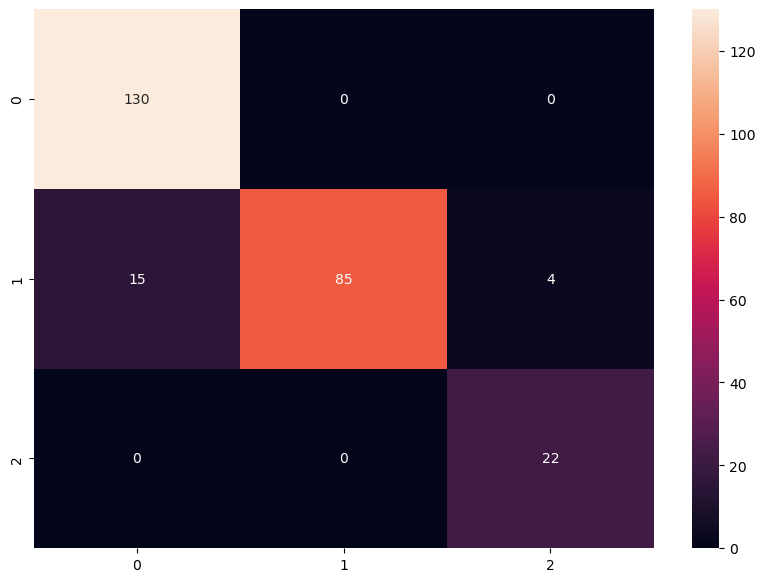

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-Epochs20.joblib"
joblib.dump(model, filename)

['Model1-Epochs20.joblib']